# Customer Lifetime Value

# 1. Business Understanding

Customer Lifetime Value adalah salah satu metrik yang mengukur total pendapatan dari seorang pelanggan selama rentang waktu tertentu. CLV membandingkan pendapatan dari setiap pelanggan dengan customer lifespan, atau sudah berapa lama orang tersebut menjadi pelanggan di suatu bisnis. metrik CLV banyak digunakan oleh perusahaan yang melakukan repeat sales kepada customer maupun perusahaan yang menggunakan sistem berlangganan dalam bisnisnya.

## 1.1 Problem 

Dalam data ini, suatu perusahaan asuransi mobil di Amerika Serikat mengalami masalah dalam meningkatkan revenue perusahaan. Salah satu penyebabnya adalah karena pendekatan strategi marketing yang tidak tepat dimana perusahaan mengeluarkan budget yang sama untuk seluruh tipe customer, sehingga perusahaan akhirnya membayar lebih untuk low-value customer dan kehilangan high-value customer. Maka dari itu, perusahaan menggunakan metrik CLV agar dapat menentukan seberapa valuable customer yang dimiliki dan strategi marketing yang akan digunakan berdasarkan CLV tersebut. Namun perusahaan asuransi mobil ini belum memiliki sistem untuk memprediksi CLV dengan cepat dan akurat sehingga penentuan strategi marketing saat ini memakan waktu lebih lama karena pengolahan data yang masih secara manual. Oleh karena itu, prediksi CLV yang lebih cepat dan akurat sangatlah penting untuk dapat mengambil strategi marketing yang lebih tepat.

## 1.2 Analysis Goal

Berdasarkan permasalahan diatas, tujuan utama dari analisa ini adalah mempermudah perusahaan asuransi mobil (khususnya divisi marketing) apabila terdapat 'tools' untuk memprediksi CLV dengan melihat dari data demografis dan data asuransi mobil customer (tipe asuransi, jumlah polis, biaya premi, total klaim, dan lainnya) sehingga pengolahan data CLV tidak lagi secara manual dan dapat mempercepat proses pengambilan keputusan strategi marketing.

## 1.3 Metric Used

Metrik yang akan digunakan adalah RMSE, MAE, dan MAPE, di mana RMSE adalah nilai rataan akar kuadrat dari error, MAE adalah rataan nilai absolut dari error, sedangkan MAPE adalah rataan persentase error yang dihasilkan oleh model regresi. Semakin kecil nilai RMSE, MAE, dan MAPE yang dihasilkan, berarti model semakin akurat dalam memprediksi CLV sesuai dengan limitasi feature yang digunakan. Akan tetapi pada hasil analisa model, akan berfokus pada RMSE

## Libraries

In [1]:
#Libraries

# ---- Data Manipulation ----
import pandas as pd
import numpy as np

# ---- Data Visualization ----
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Data Preprocessing ----
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.impute import SimpleImputer, KNNImputer
from category_encoders import BinaryEncoder, OrdinalEncoder
import category_encoders as ce

# ---- Model selection ----
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# ---- Algorithm ----
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor

# ---- Evaluation ----
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error

### Load Dataset

In [2]:
df=pd.read_csv('data_customer_lifetime_value.csv')
df.head()

,Vehicle Class,Coverage,Renew Offer Type,EmploymentStatus,Marital Status,Education,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income,Customer Lifetime Value
0,Four-Door Car,Extended,Offer1,Retired,Divorced,High School or Below,2.0,90.0,571.479602,11828.0,10083.486880
1,Four-Door Car,Basic,Offer1,Employed,Married,College,6.0,62.0,114.514440,44762.0,4943.386117
2,Two-Door Car,Basic,Offer1,Retired,Married,Master,2.0,62.0,257.248789,21514.0,11981.984810
3,Four-Door Car,Premium,Offer3,Disabled,Married,High School or Below,1.0,116.0,556.800000,17913.0,4550.856045
4,Two-Door Car,Basic,Offer3,Medical Leave,Married,High School or Below,1.0,62.0,355.820799,19030.0,2372.155492


In [3]:
# Menampilkan statistik deskriptif dari numerical & categorical variable
display(df.describe(), df.describe(include='object'))

,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income,Customer Lifetime Value
count,5669.000000,5669.000000,5669.000000,5669.000000,5669.000000
mean,2.979361,93.026989,431.407103,37868.188569,8029.874592
std,2.393187,34.551795,287.558038,30490.490723,6916.708246
min,1.000000,61.000000,0.423310,0.000000,1898.007675
25%,1.000000,68.000000,266.932542,0.000000,3954.344534
50%,2.000000,82.000000,379.200000,34322.000000,5800.188903
75%,4.000000,109.000000,549.986128,62464.000000,9031.214859
max,9.000000,297.000000,2759.794354,99934.000000,83325.381190


,Vehicle Class,Coverage,Renew Offer Type,EmploymentStatus,Marital Status,Education
count,5669,5669,5669,5669,5669,5669
unique,6,3,4,5,3,5
top,Four-Door Car,Basic,Offer1,Employed,Married,Bachelor
freq,2858,3477,2292,3541,3305,1703


## Data Cleaning

In [4]:
# Memeriksa apakah ada missing value pada dataset
print(f'Apakah terdapat missing value?', 'Ada' if df.isna().sum().any() == True else 'Tidak ada')
print(f'Jumlah data missing value: {df.isna().sum().sum()}')

Apakah terdapat missing value? Tidak ada
Jumlah data missing value: 0


## Data Exploration

<Axes: xlabel='Customer Lifetime Value'>

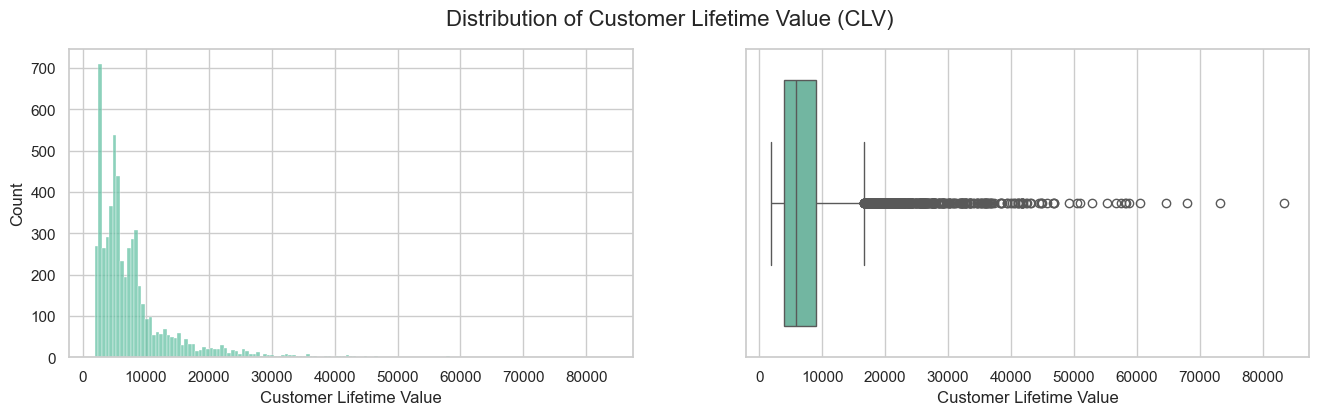

In [5]:
sns.set_theme(style='whitegrid', palette='Set2')
fig = plt.figure(figsize=(16,4))

fig.suptitle('Distribution of Customer Lifetime Value (CLV)', size=16)

plt.subplot(1,2,1)
sns.histplot(data=df, x='Customer Lifetime Value')

plt.subplot(1,2,2)
sns.boxplot(data=df, x='Customer Lifetime Value')

Berdasarkan plot di atas, terlihat bahwa data tersebut `right-skewed` dimana diartikan bahwa banyak customer dengan 'low CLV' dan sangat sedikit customer dengan 'high CLV'. Serta dalam boxplot dapat terlihat bahwa terdapat customer dengan Customer Lifetime Value yang ekstrim (outlier) pada nilai diatas ± 16000

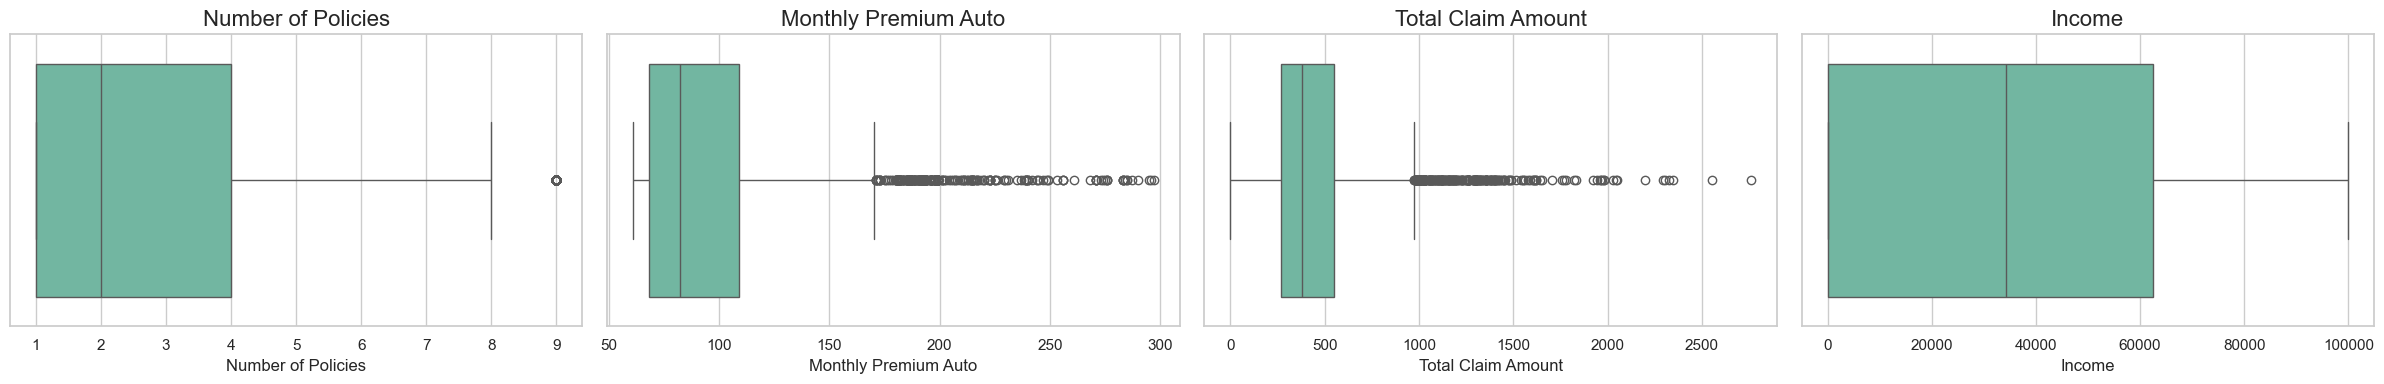

In [6]:
numerical_cols = list(df.describe().columns[:-1])

plt.figure(figsize=(24,4))
num_subplot = 1

for i in numerical_cols:
    plt.subplot(1,4,num_subplot)
    sns.boxplot(data=df, x=i)
    plt.title(i, size=16)
    plt.tight_layout()
    num_subplot+=1

Melihat dari distribusi feature numerical, diketahui bahwa feature-feature tersebut tidak terdistribusi normal (skewed) serta terdapat outlier pada feature `Number of Policies`, `Monthly Premium Auto`, dan `Total Claim Amount` dimana akan dihandling pada bagian Data Preprocessing. Namun karena saya ingin melihat korelasi feature numerical dengan target, maka diperlukan visualisasi dengan scatterplot dan heatmap

### Correlation of Numerical Feature vs Target

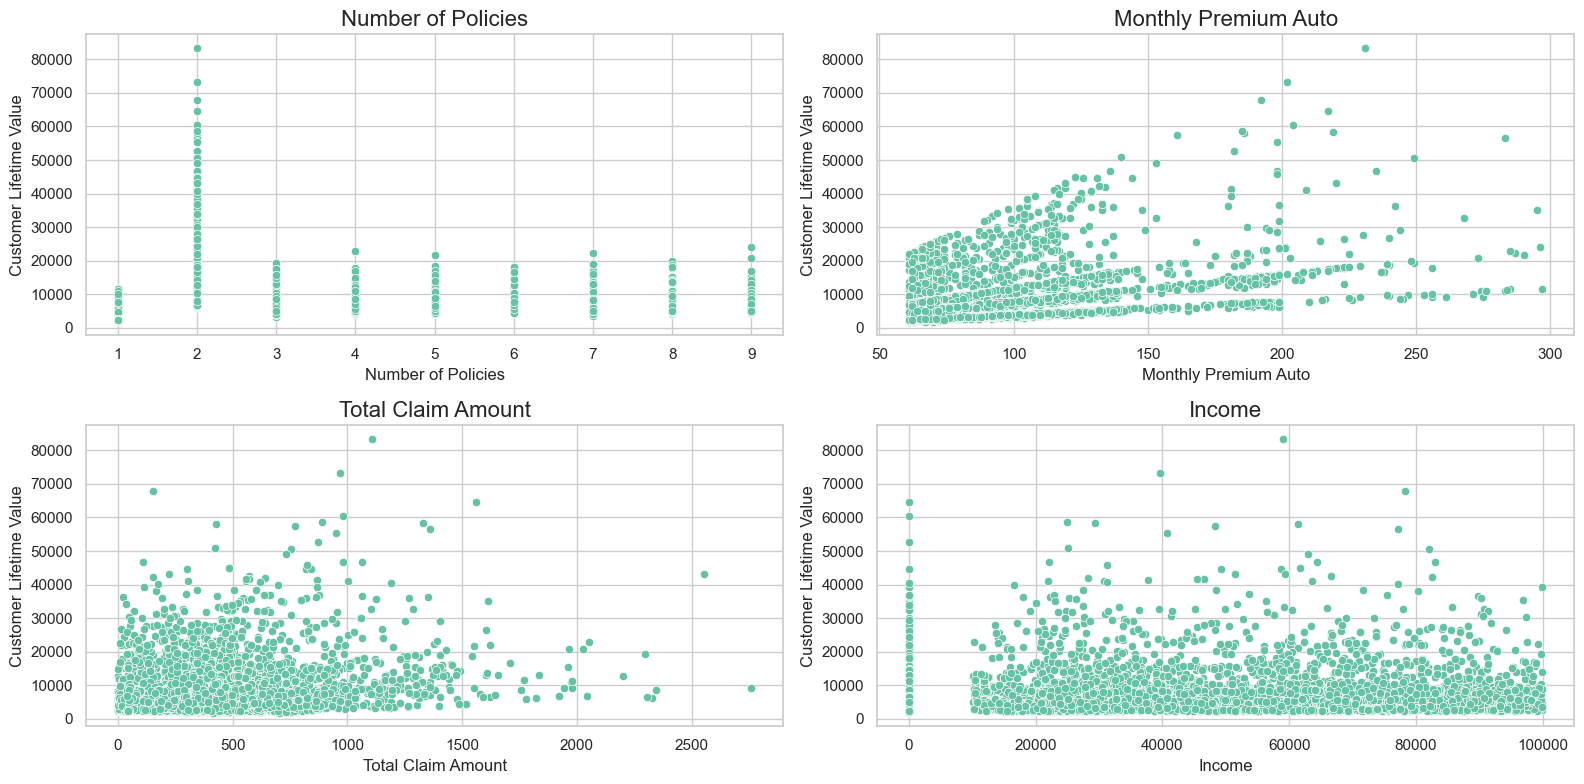

In [7]:
plt.figure(figsize=(16,8))
num_subplot = 1

for i in numerical_cols:
    plt.subplot(2,2,num_subplot)
    sns.scatterplot(data=df, x=i, y='Customer Lifetime Value')
    plt.title(i, size=16)
    plt.tight_layout()
    num_subplot+=1

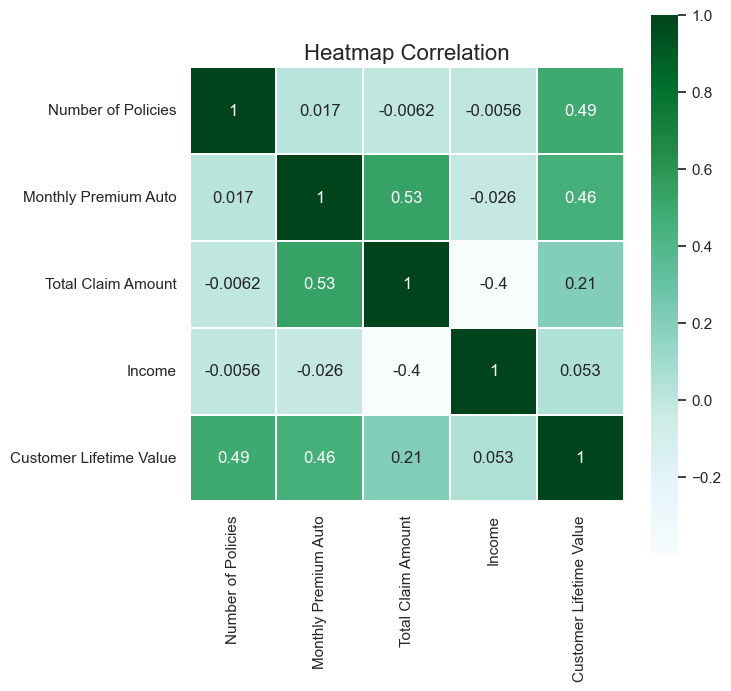

In [8]:
# Menampilkan nilai korelasi antar feature numerical vs target
numeric_columns = df.select_dtypes(include=['number'])

corr = numeric_columns.corr(method='spearman')

plt.figure(figsize=(7,7))
sns.heatmap(corr, annot=True, square=True, cmap='BuGn', linewidths=0.05)
plt.title('Heatmap Correlation', size=16)
plt.show()

Heatmap diatas menunjukkan bahwa `Customer Lifetime Value` memiliki korelasi positif terkuat dengan feature `Number of Policies` `(0.49)`. Sedangkan feature `Income` menjadi feature yang berkorelasi terlemah dengan `Customer Lifetime Value` `(0.053)`. 

### Distribution of Categorical Feature

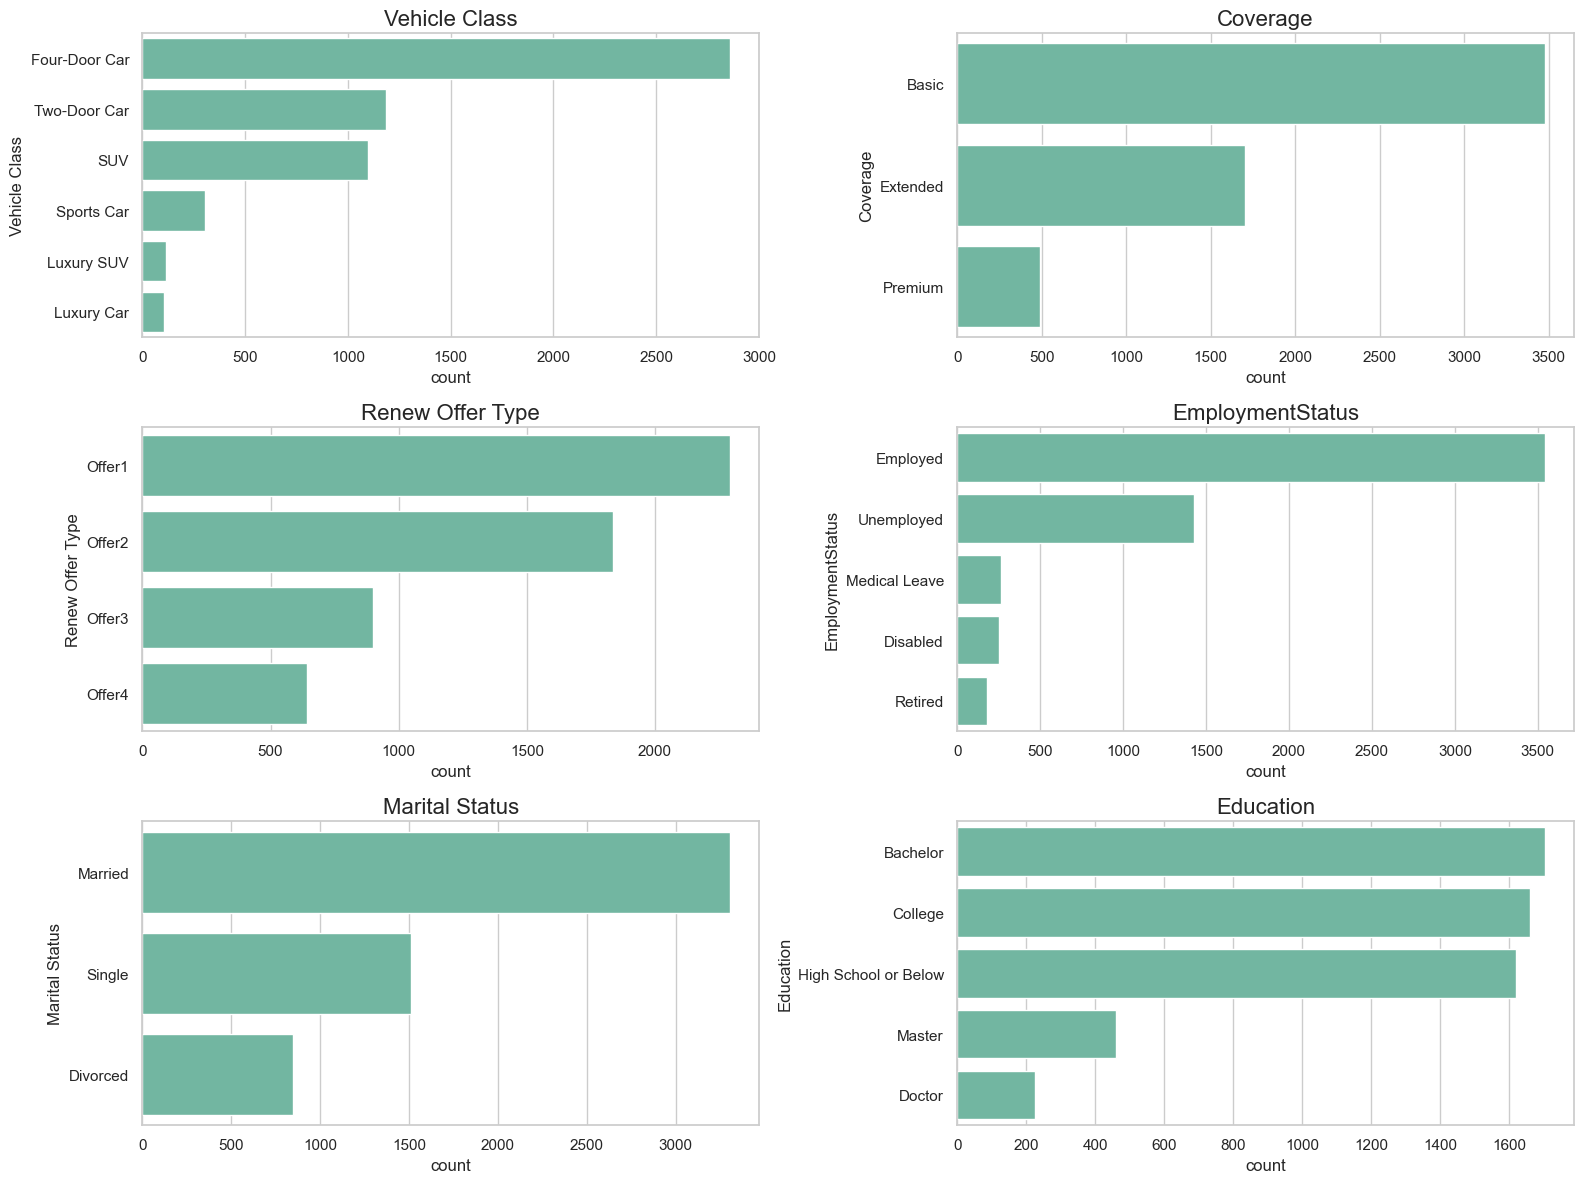

In [9]:
# Membuat variable khusus untuk feature categorical
categorical_cols = list(df.describe(include='O').columns)

plt.figure(figsize=(16,12))
num_subplot = 1

for i in categorical_cols:
    plt.subplot(3,2,num_subplot)
    sns.countplot(data=df, y=i, order=df[i].value_counts().index)
    plt.title(i, size=16)
    plt.tight_layout()
    num_subplot+=1

### Distribution of Categorical Feature vs Target

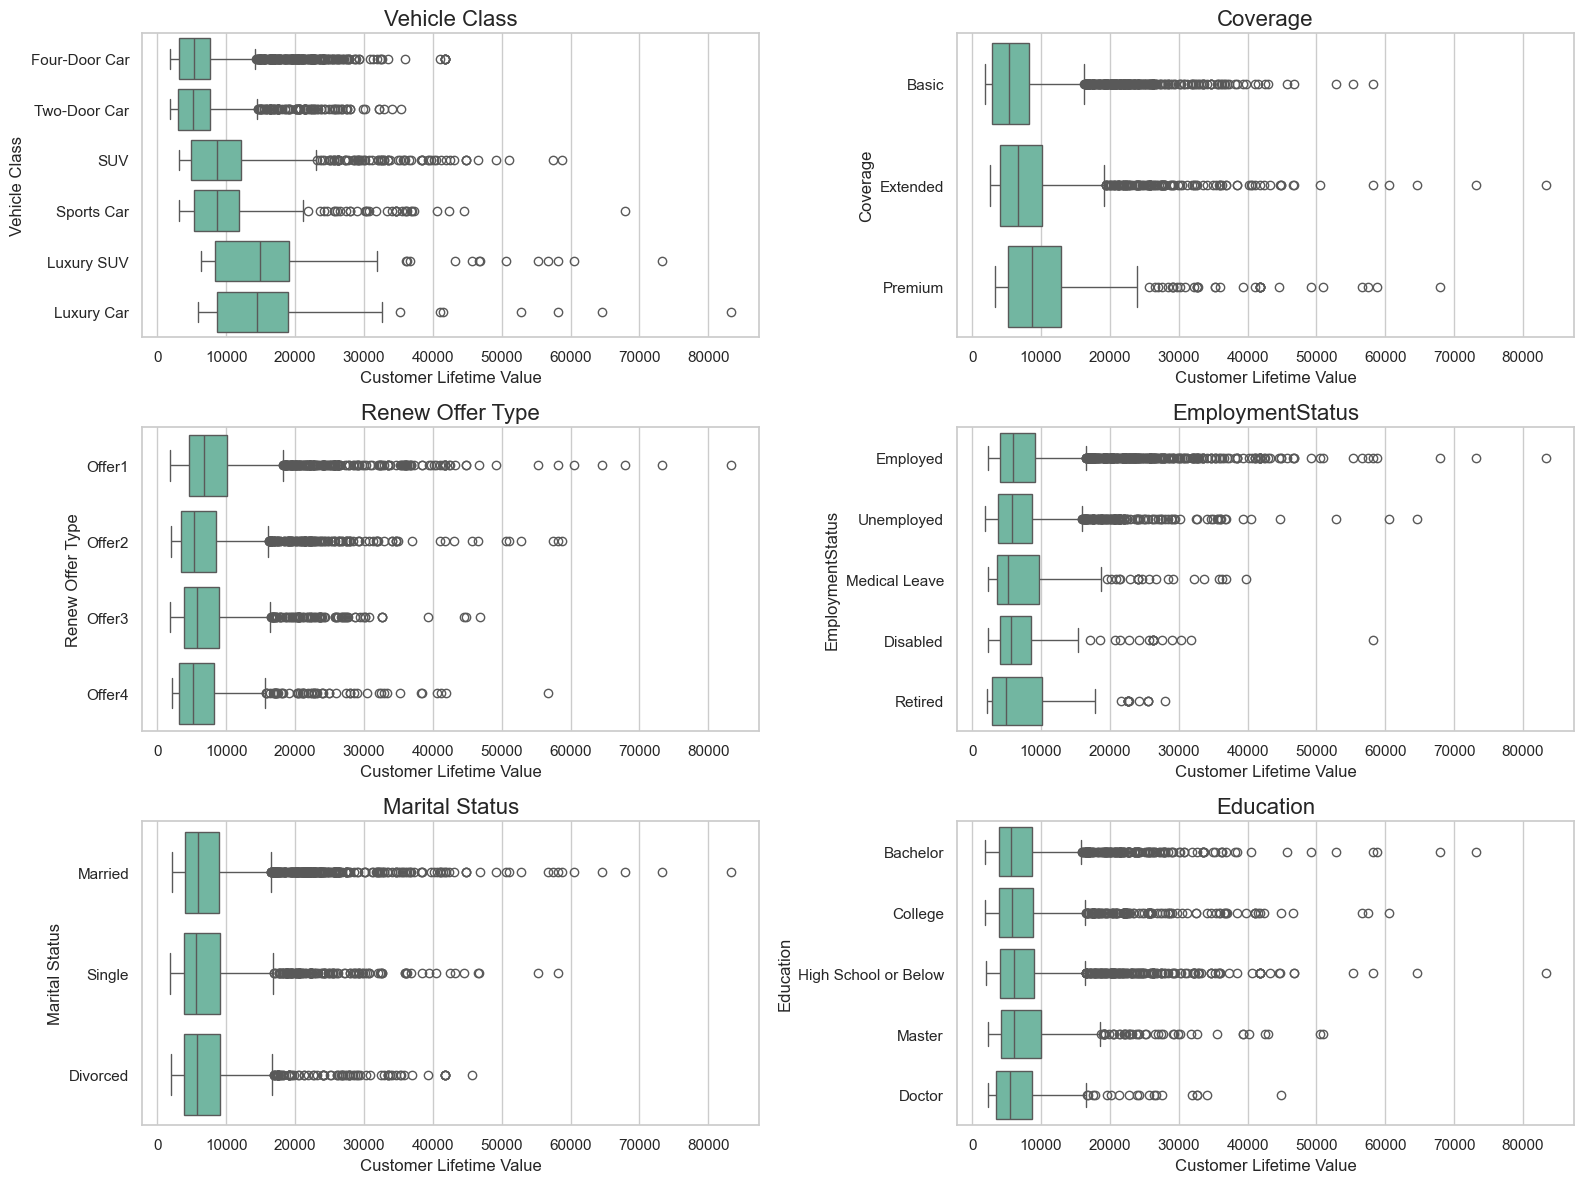

In [10]:
plt.figure(figsize=(16,12))
num_subplot = 1

for i in categorical_cols:
    plt.subplot(3,2,num_subplot)
    sns.boxplot(data=df, y=i, x='Customer Lifetime Value', order=df[i].value_counts().index)
    plt.title(i, size=16)
    plt.tight_layout()
    num_subplot+=1

## Data Preprocessing

### Drop Duplicate Data

In [11]:
df_model = df.copy()
print(f'Jumlah data duplikat: {df_model.duplicated().sum()}')

Jumlah data duplikat: 618


In [12]:
df_model[df_model.duplicated()].sort_values('Customer Lifetime Value').head()

,Vehicle Class,Coverage,Renew Offer Type,EmploymentStatus,Marital Status,Education,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income,Customer Lifetime Value
4883,Four-Door Car,Basic,Offer1,Unemployed,Divorced,College,1.0,66.0,316.8,0.0,2004.350666
3673,Four-Door Car,Basic,Offer1,Unemployed,Divorced,College,1.0,66.0,316.8,0.0,2004.350666
3524,Four-Door Car,Basic,Offer1,Unemployed,Divorced,College,1.0,66.0,316.8,0.0,2004.350666
2675,Four-Door Car,Basic,Offer1,Unemployed,Divorced,College,1.0,66.0,316.8,0.0,2004.350666
2763,Four-Door Car,Basic,Offer3,Retired,Married,High School or Below,1.0,61.0,292.8,27972.0,2227.072755


In [13]:
# Drop data duplicates
df_model = df_model.drop_duplicates()

# Menampilkan jumlah baris dan kolom setelah drop duplicates
print(f'Jumlah baris dataset: {df_model.shape[0]}\nJumlah kolom dataset: {df_model.shape[1]}')

Jumlah baris dataset: 5051
Jumlah kolom dataset: 11


### Outlier Handling

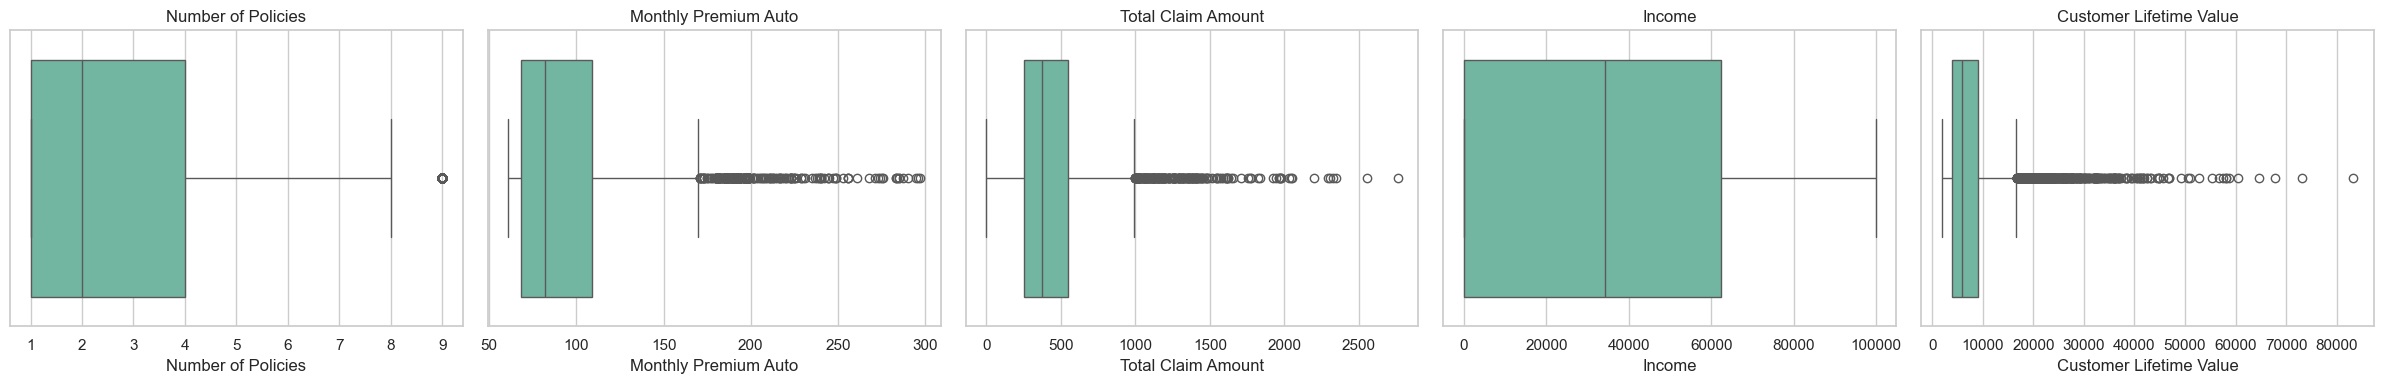

In [14]:
plt.figure(figsize=(24,4))
num_subplot = 1

for i in df.describe().columns:
    plt.subplot(1,5,num_subplot)
    sns.boxplot(data=df_model, x=i),
    plt.title(i),
    plt.tight_layout()
    num_subplot+=1

Dari boxplot diatas, terlihat adanya outlier pada beberapa feature Number of Policies, Monthly Premium Auto, Total Claim Amount, dan Customer Lifetime Value. Selanjutnya saya akan melakukan analisa pada fitur-fitur tersebut

In [15]:
def iqr_detection(data):
    q1 = df_model[data].quantile(0.25)
    q3 = df_model[data].quantile(0.75)
    iqr = q3 - q1
    limit = iqr*1.5
    print(f'Nilai IQR {data}: {iqr}')

    upper = q3 + limit
    lower = q1 - limit
    print(f'Nilai Upperbound: {upper}')
    print(f'Nilai Lowerbound: {lower}')

iqr_detection('Number of Policies')

Nilai IQR Number of Policies: 3.0
Nilai Upperbound: 8.5
Nilai Lowerbound: -3.5


In [16]:
df_model['Number of Policies'].describe()

count    5051.000000
mean        2.992081
std         2.386500
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max         9.000000
Name: Number of Policies, dtype: float64

In [17]:
# Melihat unique value dari 'Number of Policies' dan jumlah data diatas upperbound
print('Jumlah unique value pada \'Number of Policies\':', df_model['Number of Policies'].unique())
print('Jumlah data diatas nilai upperbound \'Number of Policies\':', len(df_model[df_model['Number of Policies'] > 8.5]))



Jumlah unique value pada 'Number of Policies': [2. 6. 1. 8. 5. 3. 7. 4. 9.]
Jumlah data diatas nilai upperbound 'Number of Policies': 228


In [18]:
# Melihat nilai IQR dari 'Monthly Premium Auto'
iqr_detection('Monthly Premium Auto')

Nilai IQR Monthly Premium Auto: 41.0
Nilai Upperbound: 170.5
Nilai Lowerbound: 6.5


In [19]:
# Melihat statistik deskriptif dari 'Monthly Premium Auto'
df_model['Monthly Premium Auto'].describe()

count    5051.000000
mean       92.911107
std        34.335010
min        61.000000
25%        68.000000
50%        82.000000
75%       109.000000
max       297.000000
Name: Monthly Premium Auto, dtype: float64

In [20]:
print('Jumlah data diatas nilai upperbound \'Monthly Premium Auto\':', len(df_model[df_model['Monthly Premium Auto'] > 170.5]))

Jumlah data diatas nilai upperbound 'Monthly Premium Auto': 252


Pada feature `Monthly Premium Auto` didapatkan nilai upperboundnya adalah $170.5 dan jumlah banyaknya data berdasarkan nilai upperbound tersebut adalah sebesar 252 customer. Apabila saya mendrop outlier `Monthly Premium Auto` berdasarkan nilai upperboundnya saja, tentu akan kehilangan cukup banyak data untuk dibuat dalam modeling.

In [21]:
# Melihat nilai IQR dari 'Total Claim Amount'
iqr_detection('Total Claim Amount')

# Melihat statistik deskriptif dari 'Total Claim Amount'
df_model['Total Claim Amount'].describe()


Nilai IQR Total Claim Amount: 296.34681750000004
Nilai Upperbound: 992.6433477500001
Nilai Lowerbound: -192.74392225000005


count    5051.000000
mean      429.798954
std       293.129102
min         0.423310
25%       251.776304
50%       374.400000
75%       548.123122
max      2759.794354
Name: Total Claim Amount, dtype: float64

- Mean (429.80) dan median (374.40) menunjukkan bahwa distribusi Total Claim Amount mungkin sedikit miring ke kanan (positively skewed), karena mean lebih tinggi dari median.
- Standar deviasi yang cukup tinggi (293.13) menunjukkan adanya variasi yang signifikan dalam jumlah klaim.
- IQR sebesar 296.35 menunjukkan rentang interkuartil yang cukup luas, yang berarti ada penyebaran yang cukup besar di antara nilai tengah dari Total Claim Amount.
- Nilai lower bound (-192.74) tidak masuk akal dalam konteks Total Claim Amount karena jumlah klaim tidak bisa negatif. Ini menunjukkan bahwa tidak ada klaim yang berada di bawah batas ini, tetapi nilai ini tetap dihitung secara matematis.
- Nilai upper bound (992.64) digunakan untuk mendeteksi outlier. Nilai klaim di atas 992.64 dianggap sebagai outlier dalam dataset ini.



In [22]:
print('Jumlah data diatas nilai upperbound \'Total Claim Amount\':', len(df_model[df_model['Total Claim Amount'] > 992.64]))

Jumlah data diatas nilai upperbound 'Total Claim Amount': 217


Di tahun [2019](https://www.bankrate.com/insurance/car/auto-insurance-statistics/#what-types-of-auto-insurance-claims-are-filed), dimana sumber asli data ini didapat, diketahui bahwa pemilik kendaraan pribadi dapat mengajukan klaim asuransi all risk (comprehensive claims) paling mahal mencapai $1777. Sehingga dalam hal ini saya berasumsi bahwa batas `Total Claim Amount` tertinggi adalah $1777 dan nilai diatas nominal tersebut akan saya drop.

In [23]:
# Melihat nilai IQR dari 'Customer Lifetime Value'
iqr_detection('Customer Lifetime Value')

# Melihat statistik deskriptif dari 'Customer Lifetime Value'
df_model['Customer Lifetime Value'].describe()

Nilai IQR Customer Lifetime Value: 5064.1236284999995
Nilai Upperbound: 16624.75007525
Nilai Lowerbound: -3631.744438749999


count     5051.000000
mean      8059.483178
std       6989.189674
min       1898.007675
25%       3964.441004
50%       5837.528088
75%       9028.564632
max      83325.381190
Name: Customer Lifetime Value, dtype: float64

- Dengan mean (8059.48) dan median (5837.53), kita dapat melihat bahwa distribusi CLV kemungkinan miring ke kanan (positively skewed), karena mean lebih besar dari median. Ini sering terjadi jika ada beberapa pelanggan dengan nilai CLV yang sangat tinggi yang menaikkan rata-rata.
- Standar deviasi yang tinggi (6989.19) mengindikasikan bahwa nilai-nilai CLV tersebar luas di sekitar mean, yang berarti ada banyak variasi dalam nilai CLV pelanggan.

In [24]:
print('Jumlah data diatas nilai upperbound \'Customer Lifetime Value\':', len(df_model[df_model['Customer Lifetime Value'] > 16624.75]))

Jumlah data diatas nilai upperbound 'Customer Lifetime Value': 449




Terlihat bahwa 75% data pada target `Customer Lifetime Value` bernilai kurang dari 9028.56, sedangkan nilai maksimalnya adalah 83325.38. Hal ini menunjukkan terdapat positive skewness pada distribusinya. Akan tetapi nilai upperboundnya terdapat 449 data yang `Customer Lifetime Value` lebih besar dari 16624.75. Oleh karena itu, data customer yang memiliki CLV lebih besar dari 16624.75 tidak akan dimasukkan ke dalam analisa ini d

### Drop Outliers

In [25]:
# Menggabungkan limit outlier menjadi satu dataframe
outlier = df_model[(df_model['Monthly Premium Auto'] > 224.42) | (df_model['Customer Lifetime Value'] > 16624.75) | (df_model['Total Claim Amount'] > 1777)]
len(outlier)

478

Setelah ditentukan batasan-batasan outlier yang akan didrop, kemudian semua itu dimasukkan ke 1 dataframe bernama 'outlier'. Setelah digabungkan, terdapat 478 data customer yang akan didrop sehingga akan menjadi dataset bersih yang siap untuk melakukan proses analisa

In [26]:
df_model = df_model.drop(index= outlier.index)

### Cleaned Data

In [27]:
# Cek kembali info dataset
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4573 entries, 0 to 5668
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Vehicle Class            4573 non-null   object 
 1   Coverage                 4573 non-null   object 
 2   Renew Offer Type         4573 non-null   object 
 3   EmploymentStatus         4573 non-null   object 
 4   Marital Status           4573 non-null   object 
 5   Education                4573 non-null   object 
 6   Number of Policies       4573 non-null   float64
 7   Monthly Premium Auto     4573 non-null   float64
 8   Total Claim Amount       4573 non-null   float64
 9   Income                   4573 non-null   float64
 10  Customer Lifetime Value  4573 non-null   float64
dtypes: float64(5), object(6)
memory usage: 428.7+ KB


# Data Splitting


In [28]:
# Define X dan y
X = df_model.drop(columns='Customer Lifetime Value')
y = df_model['Customer Lifetime Value']

# Data Splitting dengan proporsi test size 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 48)

In [29]:
print(X_train.shape)
print(y_train.shape)

(3658, 10)
(3658,)


In [30]:
scaling_robust_imp=Pipeline(steps=[
    ('Imputation_median', SimpleImputer(strategy='median')),
    ('Scaling_robust',RobustScaler())
])

# Encoding

Dalam machine learning, encoding merujuk pada proses mengubah data menjadi format yang dapat diproses oleh algoritma machine learning. Karena banyak algoritma machine learning hanya dapat bekerja dengan data numerik, data non-numerik seperti teks atau kategori perlu diubah menjadi representasi numerik. Ada beberapa teknik encoding yang digunakan dalam machine learning, masing-masing dengan kelebihan dan kekurangan tertentu, tergantung pada jenis data dan algoritma yang digunakan. Berikut ini adalah beberapa teknik encoding yang umum: One Hot, Ordinal, Label, Target, dan Frequency. 

Untuk kasus ini saya akan memakai encoding sebagai berikut:

- Onehot Encoder: Vehicle Class, Employment Status, Renew Offer type, Marital Status
- Ordinal Encoder: Mengubah kolom kategorikal ordinal menjadi nilai numerik berdasarkan urutan tertentu yang diberikan dalam mapping, yaitu adalah kolom Coverage dan Education
- scaling_robust_imp: Pipeline yang telah definisikan sebelumnya untuk imputasi nilai hilang dengan median dan penskalaan data menggunakan RobustScaler dan memilih semua kolom numerik dari X_train.



In [31]:
ordinal_mapping = [
    {'col':'Coverage', 'mapping':{'Basic':1, 'Extended':2, 'Premium':3, None:0}},
    {'col':'Education', 'mapping':{'High School or Below':1, 'College':2, 'Bachelor':3, 'Master':4, 'Doctor':5, None:0}}
]

In [32]:
transformer = ColumnTransformer([
    ('OneHotEncoder', OneHotEncoder(drop='first'), ['Vehicle Class', 'EmploymentStatus', 'Renew Offer Type', 'Marital Status']),
    ('OrdinalEncoder', OrdinalEncoder(cols=['Coverage', 'Education'], mapping=ordinal_mapping), ['Coverage', 'Education']),
    # ('Scaling_Robust_Imp',scaling_robust_imp, X_train.select_dtypes('number').columns)
], remainder='passthrough')

In [33]:
# Define scaler
robust = RobustScaler()

In [34]:
# Define algoritma yang digunakan
lr = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state= 0)
rf = RandomForestRegressor(random_state= 0)
xgb = XGBRegressor(random_state= 0)

model = [lr, knn, dt, rf,xgb]

# Metric Evaluation

Evaluasi metrik yang akan digunakan adalah RMSE, MAE, dan MAPE, di mana RMSE adalah nilai rataan akar kuadrat dari error, MAE adalah rataan nilai absolut dari error, sedangkan MAPE adalah rataan persentase error yang dihasilkan oleh model regresi. Semakin kecil nilai RMSE, MAE, dan MAPE yang dihasilkan, berarti model semakin akurat dalam memprediksi CLV sesuai dengan limitasi feature yang digunakan.

Pada dasarnya, RMSE sangatlah sensitif terhadap outlier karena memberikan bobot nilai residual lebih besar dengan dikuadratkan terlebih dahulu, sehingga nilai RMSE akan lebih besar daripada MAE. Namun RMSE berguna untuk mengevaluasi model dengan 'menghukum' residual yang besar lebih banyak daripada MAE. Kekurangan RMSE adalah lebih sulit diinterpretasikan, sehingga saya juga menggunakan MAE untuk mengevaluasi model karena rataan errornya diabsolutkan dan lebih mudah diinterpretasikan. Selain itu, saya juga menggunakan MAPE untuk dapat lebih memudahkan pihak lain memahami persentase error dari model yang dibangun.

In [35]:
score_RMSE = []
list_mean_RMSE = []
list_std_RMSE = []
score_MAE = []
list_mean_MAE = []
list_std_MAE = []
score_MAPE = []
list_mean_MAPE = []
list_std_MAPE = []

# Evaluation Metrics yang digunakan
scoring = {'rmse': 'neg_root_mean_squared_error',
           'mae': 'neg_mean_absolute_error',
           'mape': 'neg_mean_absolute_percentage_error'}

In [36]:
for i in model:
    pipe_model = Pipeline([
        ('prep', transformer),
        ('scaler', robust),
        ('algo', i)
    ])

    # Cross validation untuk mencari model terbaik
    cv_score = cross_validate(
        estimator= pipe_model,
        X= X_train, 
        y= y_train,
        scoring= scoring,
        cv = 5
    )

    # RMSE Score
    score_RMSE.append(cv_score['test_rmse'])
    list_mean_RMSE.append(cv_score['test_rmse'].mean())
    list_std_RMSE.append(cv_score['test_rmse'].std())

    # MAE Score
    score_MAE.append(cv_score['test_mae'])
    list_mean_MAE.append(cv_score['test_mae'].mean())
    list_std_MAE.append(cv_score['test_mae'].std())

    # MAPE Score
    score_MAPE.append(cv_score['test_mape'])
    list_mean_MAPE.append(cv_score['test_mape'].mean())
    list_std_MAPE.append(cv_score['test_mape'].std())

In [37]:
## Coba tambahi xgboost
cvresult_before_tuning = pd.DataFrame({
    'model' : ['Linear Regression', 'KNN', 'Decision Tree', 'Random Forest','XGBoost'],
    'mean_RMSE': list_mean_RMSE,
    'std_RMSE': list_std_RMSE,
    'mean_MAE': list_mean_MAE,
    'std_MAE': list_std_MAE,
    'mean_MAPE': list_mean_MAPE,
    'std_MAPE': list_std_MAPE,
}).round(3)

cvresult_before_tuning

,model,mean_RMSE,std_RMSE,mean_MAE,std_MAE,mean_MAPE,std_MAPE
0,Linear Regression,-2727.097,79.875,-2028.337,45.150,-0.369,0.013
1,KNN,-2738.832,71.829,-1850.806,58.825,-0.337,0.019
2,Decision Tree,-1273.358,162.199,-457.790,61.143,-0.058,0.006
3,Random Forest,-921.636,94.547,-354.840,39.626,-0.043,0.004
4,XGBoost,-990.340,64.174,-436.887,23.487,-0.067,0.002


Berdasarkan cross validation diatas, diketahui bahwa terdapat perbedaan hasil antara nilai RMSE dan MAE dimana nilai RMSE cenderung lebih tinggi, sedangkan nilai residual MAE diabsolutkan sehingga lebih kecil. Nilai RMSE juga lebih tinggi karena RMSE memberikan bobot lebih besar pada nilai residual yang besar (sensitif kepada residual outlier). Dengan kata lain, terdapat nilai-nilai error yang besar yang dihasilkan oleh semua algoritma yang digunakan, sehingga ada perbedaan signifikan antara nilai RMSE dan MAE.

- Berdasarkan nilai RMSE, MAPE dan MAE, Random Forest adalah model terbaik. 
- Model ke-2 yang terbaik adalah XGBoost apabila dilihat dari RMSE dan MAE, sedangkan jika berdasarkan MAPE, Random Forest memiliki nilai paling rendah.
- Selanjutnya, akan dilakukan prediksi pada test set dengan 2 benchmark model terbaik, yaitu XGBoost dan RandomForest.



## Predict to Test Set with Benchmark Mode

Prediksi dengan 2 model terbaik yaitu XGBoost dan Random Forest

In [38]:
# Benchmark 2 model terbaik
test_models = [rf, xgb]

nilai_rmse =[]
nilai_mae =[]
nilai_mape =[]

# Prediksi pada test set
for i in test_models:
    pipe_model = Pipeline([
        ('prep', transformer),
        ('scaler', robust),
        ('algo', i)
    ])

    # Fitting & predict
    pipe_model.fit(X_train, y_train)
    yPred = pipe_model.predict(X_test)

    # Menghitung RMSE, MAE, dan MAPE dan digabung dalam list
    nilai_rmse.append(np.sqrt(mean_squared_error(y_test, yPred)))
    nilai_mae.append(mean_absolute_error(y_test, yPred))
    nilai_mape.append(mean_absolute_percentage_error(y_test, yPred))

In [39]:
score_before_tuning = pd.DataFrame({
    'RMSE': nilai_rmse,
    'MAE': nilai_mae,
    'MAPE': nilai_mape},
    index=['RandomForest', 'XGBoost']).round(3)

score_before_tuning

,RMSE,MAE,MAPE
RandomForest,1104.539,431.101,0.049
XGBoost,1150.339,509.939,0.073


Menurut hasil yang didapat, kedua metode hasilnya menurun, akan tetapi saya akan menggunakan XGBoost karena jumlah selisih nilai MAPE dan RMSE dari sebelum di tuning dan sesudah tuning terlihat sangat signifikan dibandingkan Random Forest. Oleh karena itu XGBoost yang akan dipilih.

| Method| RMSE Before | MAE Before | MAPE Before | RMSE After | MAE After | MAPE After |
| --- | --- | --- | --- | --- | --- | --- |
| RandomForest | -921.636 | -354.840 | -0.043 |-917.867 | -404.055 | -0.052 |
| XGBoost | -990.340 | -436.887 | -0.067 | -916.025 | -395.742 | -0.050 |

| Method | Selisih RMSE | Selisih MAE | Selisih MAPE |
| --- | --- | --- | --- |
| RandomForest | 4 | 50 | 9 |
| XGBoost | 74 | 41 | 17 |

## Hyperparameter Tuning

Karena XGBoost memiliki performa yang lebih baik dari RandomForest, maka selanjutnya model XGBoost ini akan dipakai sebagai model akhir. Pada tahap ini, kita akan melakukan hyperparameter tuning pada model XGBoost dengan harapan dapat meningkatkan performa model.

In [40]:
standard = StandardScaler()
minmax = MinMaxScaler()

scaler = [robust, standard, minmax]

In [41]:
# depth of tree
max_depth = list(np.arange(3,10))

# learning rate
learning_rate = [1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01]

# number of tree
n_estimators = [100, 200, 300, 400, 500]

# number of train set in each tree (% of total number of train set rows)
subsample = list(np.arange(2,11)/10)

# number of features used for splitting in tree (% of total number of train set columns)
max_features = list(np.arange(1,10)/10)
max_features.append(None)

# Hyperparameter space GBR
hyperparam_space_xgb = {
    'algo__max_depth':max_depth , 
    'algo__learning_rate':learning_rate,
    'algo__n_estimators':n_estimators,
    'algo__subsample':subsample,
    'algo__max_features':max_features,
    'scaler': scaler
}

In [42]:
pipe_xgb = Pipeline([
    ('prep', transformer),
    ('scaler', robust),
    ('algo', xgb)
])

# Hyperparameter tuning dengan RandomizedSearch
random_xgb = RandomizedSearchCV(
    estimator= pipe_xgb,
    param_distributions= hyperparam_space_xgb,
    n_iter= 200,
    cv = 5,
    scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
    n_jobs= -1,
    refit = 'neg_root_mean_squared_error',             
    random_state= 0
)

In [43]:
random_xgb.fit(X_train, y_train)

c:\Users\Bryan\anaconda3\envs\JCDS0212\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:51:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('OneHotEncoder',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Vehicle '
                                                                                'Class',
                                                                                'EmploymentStatus',
                                                                                'Renew '
                                                                                'Offer '
                                                                                'Type',
                                                                                'Marital '
                                                                                'Status']),
                                                                              ('OrdinalEncoder',
                                                                               OrdinalEncoder(cols=['Coverage',
                                                                                                    'Education'],
                                                                                              mapping=[{'col': 'Coverage',
                                                                                                        'data_type': dtype('O'),...
                                        'algo__max_features': [0.1, 0.2, 0.3,
                                                               0.4, 0.5, 0.6,
                                                               0.7, 0.8, 0.9,
                                                               None],
                                        'algo__n_estimators': [100, 200, 300,
                                                               400, 500],
                                        'algo__subsample': [0.2, 0.3, 0.4, 0.5,
                                                            0.6, 0.7, 0.8, 0.9,
                                                            1.0],
                                        'scaler': [RobustScaler(),
                                                   StandardScaler(),
                                                   MinMaxScaler()]},
                   random_state=0, refit='neg_root_mean_squared_error',
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error'])

In [44]:
pd.DataFrame(random_xgb.cv_results_).sort_values(\
    by=['rank_test_neg_root_mean_squared_error','rank_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_percentage_error']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scaler,param_algo__subsample,param_algo__n_estimators,param_algo__max_features,param_algo__max_depth,param_algo__learning_rate,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
41,0.358232,0.081594,0.016165,0.003960,RobustScaler(),0.6,400,0.5,3,0.025,...,22.444852,28,-0.046252,-0.049911,-0.044618,-0.049058,-0.048896,-0.047747,0.001987,31
25,0.330476,0.088353,0.023522,0.005408,RobustScaler(),1.0,200,None,4,0.025,...,27.026039,12,-0.041186,-0.042544,-0.040070,-0.046164,-0.045181,-0.043029,0.002317,14
29,0.661561,0.230909,0.024821,0.008930,RobustScaler(),0.7,400,0.1,4,0.01,...,30.024325,17,-0.042516,-0.045206,-0.042356,-0.048368,-0.048937,-0.045477,0.002790,16
113,0.421604,0.057565,0.029915,0.006550,RobustScaler(),1.0,400,0.2,3,0.05,...,25.227189,52,-0.051205,-0.054684,-0.049035,-0.055102,-0.054632,-0.052932,0.002401,53
22,0.698712,0.196290,0.027109,0.007416,MinMaxScaler(),0.9,500,0.9,4,0.025,...,24.161032,23,-0.048175,-0.052498,-0.044769,-0.049629,-0.050396,-0.049093,0.002574,39


In [45]:
print('XGBoost (by RandomizedSearchCV')
print('Best_score:', random_xgb.best_score_)
print('Best_params:', random_xgb.best_params_)

XGBoost (by RandomizedSearchCV
Best_score: -866.2800086340567
Best_params: {'scaler': RobustScaler(), 'algo__subsample': 0.6, 'algo__n_estimators': 400, 'algo__max_features': 0.5, 'algo__max_depth': 3, 'algo__learning_rate': 0.025}


RMSE before tuning: 966

RMSE after tuning (Randomized Search) 866

- Scaler : Robust
- Subsample : 0,6
- Estimator : 400
- Max Features : 0,5
- Max Depth : 3
- Learning rate : 0,025

Kemudian selanjutnya saya mencoba tuning menggunakan GridSearch dengan mempersempit nilai dalam hyperparam_space-nya dengan harapan performa model lebih baik dari sebelumnya.


## GridSearchCV

GridSearch dilakukan khusus untuk parameter XGBoost saja, untuk scaler tidak dituning kembali karena sudah mendapatkan scaler terbaiknya melalui RandomizedSearch.

In [46]:
max_depth = [3, 4, 7]
learning_rate = [0.1, 0.025, 0.01]
n_estimators = [200, 400, 500]
subsample = [0.4, 0.6, 0.8, 1]
max_features = [0.5, 0.6, None]

# Hyperparameter space XGBoost
hyperparam_space_xgb = {
    'algo__max_depth':max_depth , 
    'algo__learning_rate':learning_rate,
    'algo__n_estimators':n_estimators,
    'algo__subsample':subsample,
    'algo__max_features':max_features,
}

In [47]:
# Membuat algorithm chains
pipe_xgb = Pipeline([
    ('prep', transformer),
    ('scaler', robust),
    ('algo', xgb)
])

# Hyperparameter tuning dengan GridSearch
grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid= hyperparam_space_xgb,
    cv= 5,
    scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
    refit = 'neg_root_mean_squared_error',
    n_jobs= -1,                          
    verbose= 1,
)

In [48]:
grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\Bryan\anaconda3\envs\JCDS0212\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:52:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('OneHotEncoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Vehicle '
                                                                          'Class',
                                                                          'EmploymentStatus',
                                                                          'Renew '
                                                                          'Offer '
                                                                          'Type',
                                                                          'Marital '
                                                                          'Status']),
                                                                        ('OrdinalEncoder',
                                                                         OrdinalEncoder(cols=['Coverage',
                                                                                              'Education'],
                                                                                        mapping=[{'col': 'Coverage',
                                                                                                  'data_type': dtype('O'),
                                                                                                  'mappi...
                                                     random_state=0, ...))]),
             n_jobs=-1,
             param_grid={'algo__learning_rate': [0.1, 0.025, 0.01],
                         'algo__max_depth': [3, 4, 7],
                         'algo__max_features': [0.5, 0.6, None],
                         'algo__n_estimators': [200, 400, 500],
                         'algo__subsample': [0.4, 0.6, 0.8, 1]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'],
             verbose=1)

In [49]:
pd.DataFrame(grid_xgb.cv_results_).sort_values(\
    by=['rank_test_neg_root_mean_squared_error','rank_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_percentage_error']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algo__learning_rate,param_algo__max_depth,param_algo__max_features,param_algo__n_estimators,param_algo__subsample,params,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
145,0.236833,0.045819,0.017903,0.003193,0.025,4,0.5,200,0.6,"{'algo__learning_rate': 0.025, 'algo__max_dept...",...,28.016675,49,-0.039726,-0.043119,-0.038940,-0.045207,-0.045225,-0.042443,0.002664,37
157,0.356943,0.103354,0.018761,0.004883,0.025,4,0.6,200,0.6,"{'algo__learning_rate': 0.025, 'algo__max_dept...",...,28.016675,49,-0.039726,-0.043119,-0.038940,-0.045207,-0.045225,-0.042443,0.002664,37
169,0.276020,0.039305,0.021585,0.007085,0.025,4,None,200,0.6,"{'algo__learning_rate': 0.025, 'algo__max_dept...",...,28.016675,49,-0.039726,-0.043119,-0.038940,-0.045207,-0.045225,-0.042443,0.002664,37
146,0.241332,0.046091,0.013941,0.008259,0.025,4,0.5,200,0.8,"{'algo__learning_rate': 0.025, 'algo__max_dept...",...,27.417099,34,-0.040112,-0.042121,-0.038916,-0.045206,-0.045191,-0.042309,0.002572,28
158,0.250738,0.045734,0.017996,0.006832,0.025,4,0.6,200,0.8,"{'algo__learning_rate': 0.025, 'algo__max_dept...",...,27.417099,34,-0.040112,-0.042121,-0.038916,-0.045206,-0.045191,-0.042309,0.002572,28


In [50]:
print('XGBoost (by GridSearchCV')
print('Best_score:', grid_xgb.best_score_)
print('Best_params:', grid_xgb.best_params_)

XGBoost (by GridSearchCV
Best_score: -862.2255945400681
Best_params: {'algo__learning_rate': 0.025, 'algo__max_depth': 4, 'algo__max_features': 0.5, 'algo__n_estimators': 200, 'algo__subsample': 0.6}


RMSE before tuning: 966

RMSE after tuning 866 (Random Search)

RMSE after tuning 862 (Grid Search)

- Subsample : 0,6
- Estimator : 200
- Max Features : 0,5
- Max Depth : 4
- Learning rate : 0,025

Dengan parameter yang relatif mirip dengan hasil RandomizedSearch, ternyata tuning menggunakan GridSearch menghasilkan performa model yang lebih baik.



Performance terbaik adalah setelah melakukan Gridsearch pada model. Oleh karena itu model setelah hasil dari Gridsearch yang akan dipilih sebagai best model

## XGBoost

XGBoost adalah library peningkatan gradien terdistribusi yang dioptimalkan dan dirancang untuk pelatihan model pembelajaran mesin yang efisien dan skalabel. Ini adalah metode pembelajaran ansambel yang menggabungkan prediksi beberapa model lemah untuk menghasilkan prediksi yang lebih kuat.

Ini juga menyediakan kerangka peningkatan gradien untuk C++, Java, Python, R, Julia, Perl, dan Scala. Ini adalah algoritma pembelajaran mesin yang memberikan hasil luar biasa di berbagai bidang seperti klasifikasi, regresi, dan pemeringkatan.

## Predict to Test Set with Best Model

In [51]:
xgb_tuning = grid_xgb.best_estimator_

# Fitting model
xgb_tuning.fit(X_train, y_train)

# Predict test set
y_pred_xgb_tuning = xgb_tuning.predict(X_test)

# Simpan nilai metrics RMSE, MAE & MAPE setelah tuning
rmse_xgb_tuning = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuning))
mae_xgb_tuning = mean_absolute_error(y_test, y_pred_xgb_tuning)
mape_xgb_tuning = mean_absolute_percentage_error(y_test, y_pred_xgb_tuning)

score_after_tuning_gbr = pd.DataFrame({'RMSE': rmse_xgb_tuning, 'MAE': mae_xgb_tuning, 'MAPE': mape_xgb_tuning}, index= ['xgb']).round(3)
score_after_tuning_gbr

c:\Users\Bryan\anaconda3\envs\JCDS0212\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:52:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)


,RMSE,MAE,MAPE
xgb,1077.089,425.08,0.049


## Performance Compare

In [52]:
# After Tuning
print("After Tuning: ")
score_after_tuning_gbr

After Tuning: 


,RMSE,MAE,MAPE
xgb,1077.089,425.08,0.049


In [53]:
# Before Tuning
print("Before Tuning: ")
score_before_tuning.loc[['XGBoost']]

Before Tuning: 


,RMSE,MAE,MAPE
XGBoost,1150.339,509.939,0.073


- RMSE, MAE & MAPE sebelum tuning: 1150, 509, 0.073
- RMSE, MAE & MAPE setelah tuning: 1077,425, 0.049

## Evaluation by Residual Plot

Hasil prediksi dari model XGBoost diatas dapat kita evaluasi dengan menggunakan graphical summary, yaitu residual plot. Residual plot adalah scatter plot antara nilai prediksi pada sumbu x dan residual pada sumbu y. Dengan residual plot ini kita juga dapat melihat seberapa jauh hasil prediksi kita dapat meleset.

In [54]:
# Membuat dataframe berisi data observasi, hasil prediksi, dan residual
df_result = df_model[['Customer Lifetime Value']].copy()
df_result['yPred'] = xgb_tuning.predict(X)
df_result['residual'] = df_result['Customer Lifetime Value'] - df_result['yPred']
df_result

,Customer Lifetime Value,yPred,residual
0,10083.486880,10393.532227,-310.045347
1,4943.386117,5188.652832,-245.266715
2,11981.984810,8491.677734,3490.307076
3,4550.856045,4446.335938,104.520108
4,2372.155492,2493.197510,-121.042018
...,...,...,...
5663,8114.409136,8770.971680,-656.562544
5664,2442.216651,2574.865234,-132.648583
5665,12904.943360,12932.571289,-27.627929
5666,2447.053134,2477.826660,-30.773526


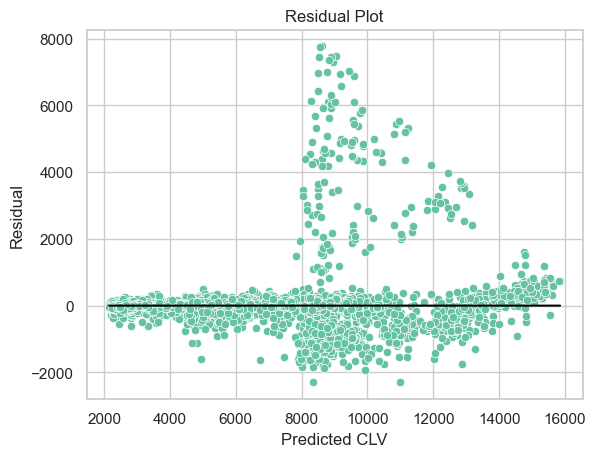

In [55]:
sns.scatterplot(data=df_result, x='yPred', y='residual').set(xlabel='Predicted CLV', ylabel='Residual')
plt.title('Residual Plot')
sns.lineplot(data=df_result, x='yPred', y=0, color='black')
plt.show()


Residual plot diatas menunjukkan bahwa prediksi model ini cukup akurat untuk memprediksi CLV < 8000 karena terlihat dengan banyaknya nilai error yang mendekati nilai 0. Diatas 8000 menunjukkan bahwa variance dari residual tidak seragam (terdapat nilai yang overprediction (error mencapai 2000) dan underprediction (error mencapai 7000))

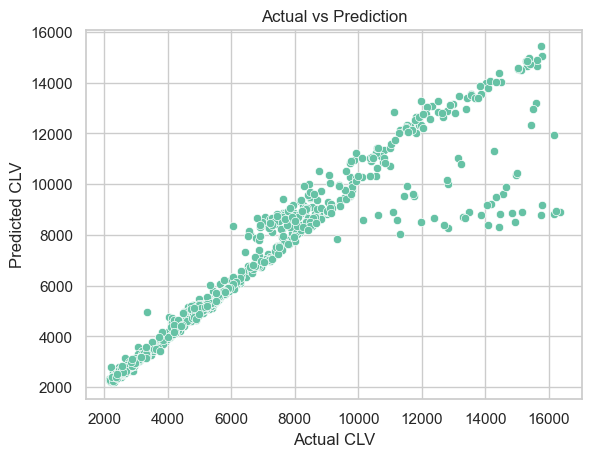

In [56]:
sns.scatterplot(x=y_test, y=y_pred_xgb_tuning).set(xlabel='Actual CLV', ylabel='Predicted CLV')
plt.title('Actual vs Prediction')
plt.show()

## Feature Importance

In [57]:
f_onehot = transformer.named_transformers_['OneHotEncoder'].get_feature_names_out()
f_ordinal = transformer.transformers[1][1].cols
f_remain = X_train.iloc[:, transformer.transformers_[2][2]].columns
all_feat = list(f_onehot) + list(f_ordinal) + list(f_remain)

feature_imp = pd.DataFrame({
    'feature' : all_feat,
    'imp' : xgb_tuning['algo'].feature_importances_
}).sort_values('imp', ascending=False)

feature_imp

,feature,imp
16,Number of Policies,0.651412
17,Monthly Premium Auto,0.140577
14,Coverage,0.088960
6,EmploymentStatus_Medical Leave,0.013579
9,Renew Offer Type_Offer2,0.012581
5,EmploymentStatus_Employed,0.011305
19,Income,0.011294
18,Total Claim Amount,0.009769
7,EmploymentStatus_Retired,0.008246
15,Education,0.008148


Text(0.5, 1.0, 'Feature Importance')

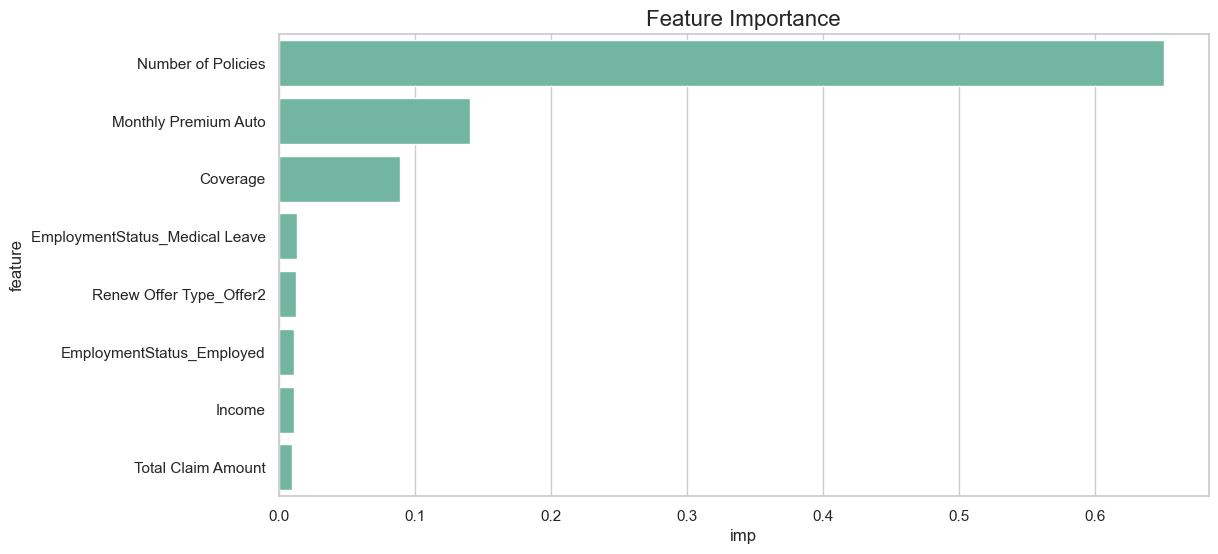

In [58]:
plt.figure(figsize=(12,6))
sns.barplot(data=feature_imp.head(8), x='imp', y='feature')
plt.title('Feature Importance', size=16)

# Conclusion

Pada modeling yang sudah dilakukan, feature `Number of Policies` dan `Monthly Premium Auto` menjadi feature yang paling berpengaruh terhadap `Customer Lifetime Value`. 

Metrik evaluasi yang digunakan pada model adalah nilai RMSE, MAE, dan MAPE. Jika ditinjau dari nilai MAE (karena lebih mudah diinterpretasikan) yang dihasilkan setelah dilakukannya hyperparameter tuning yaitu `425`, akan tetapi hal ini tidak menutup kemungkinan prediksinya meleset lebih jauh karena terdapat variance yang tidak seragam pada residual plot (estimasi pada CLV > 8000). Bias yang dihasilkan dari model ini dapat dikarenakan oleh kurangnya feature dan data pada dataset yang bisa lebih merepresentasikan nilai CLV

# Model Limitation

Untuk menjadi perhatian, model ini memiliki limitasi dalam memprediksi nilai CLV dimana apabila model ini dideploy dan terdapat data yang melebihi limitasi model, maka hasilnya menjadi kurang akurat. Adapun limitasi model sebagai berikut:
- Maksimal biaya premi asuransi mobil (`Monthly Premium Auto`) = $224.42
- Maksimal total klaim (`Total Claim Amount`) = $1777

# Business Recommendation

1. Perusahaan membuat personalized offer kepada customer agar dapat lebih menjawab kebutuhan customer berdasarkan jumlah polis dan biaya premi yang dibayarkan, karena `Number of Policies` & `Monthly Premium Auto` paling berpengaruh. Personalized offer ini akan menguntungkan karena budget marketing yang akan digunakan pun juga lebih personalized sehingga menghindari adanya membayar lebih untuk low-value customer dan kehilangan high-value customer.

2. Perusahaan sebaiknya melakukan upselling dan cross-selling kepada customer. Dengan upselling dan cross-selling ini akan memberi peluang kepada penambahan pembelian polis dan biaya premi yang dibayarkan dimana berpotensi meningkatkan CLV customer juga.

# Guide of How Use This Model




1. Import library pickle untuk load model
2. Membuat variable untuk scaler dan transformer
3. Melakukan metric evaluation untuk mencari nilai RMSE, MAE, dan MAPE
4. Ada 5 model yang keluar dari hasil metric evaluation, pilih 2 yang akan di predict
5. Setelah di predict, pilih 1 model yang paling baik untuk menganalisa data 
6. Lakukan RandomizedSearch dan GridSearch untuk mendapatkan nilai terbaik
7. Lakukan evaluasi dari residual plot. 
8. Gunakan transformer untuk mengeluarkan feature importance. Gunanya adalah untuk menunjukkan fitur yang paling berpengaruh

In [66]:
import pickle

xgb_tuning = grid_xgb.best_estimator_
xgb_tuning


xgb_tuning.fit(X, y)

pickle.dump(xgb_tuning, open('model_xgboost_CLV.sav', 'wb'))

c:\Users\Bryan\anaconda3\envs\JCDS0212\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:48:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)


In [60]:
# Load model
# file_model = 'model_xgbboost_CLV.sav'
# model_loaded = pickle.load(open(file_model, 'rb'))